# Example with Resnet50

## Pre -trained model
Tensorflow Keras provides a pre-trained model to be re-used and extended.     
Here is presented the code, using Resnet50 trained with the imagenet data.    
Reference: https://keras.io/api/applications/#resnet50

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
import numpy as np
import pandas as pd

In [2]:
baseModel = ResNet50(weights="imagenet", include_top=True, input_tensor=Input(shape=(224, 224, 3)))

Now, we use the model to classify our images.     
So, first we define a function 'classify_image' that uses the model to predict the class for a given image.    
Then, we use two images from our cardboard and glass sets, to see which is the assigned class by this pre-trained model. 

Since the model is trained to provide a huge variety of classes, we print the top 3 to better visualize which is the result.  

In [3]:
def classify_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds # [(class, description, probability)]

In [4]:
img_path = 'dataset-resized/test/cardboard/cardboard116.jpg'
preds = classify_image(img_path, baseModel)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n04548362', 'wallet', 0.67243), ('n03014705', 'chest', 0.12304134), ('n02971356', 'carton', 0.038968828)]


In [5]:
img_path = 'dataset-resized/training/glass/glass10.jpg'
preds = classify_image(img_path, baseModel)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n03983396', 'pop_bottle', 0.20891705), ('n04070727', 'refrigerator', 0.20570242), ('n03742115', 'medicine_chest', 0.1386032)]


## Adapt to our case
Now, it is time to create our network!. It has as input the output from the pre-trained model. We add some layers to reach to the 6 classes that our dataset has. After our model is ready, we can visualize the final arquitecture of the network.

In [6]:
# Reference: https://www.pyimagesearch.com/2020/04/27/fine-tuning-resnet-with-keras-tensorflow-and-deep-learning/
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(6, activation="softmax")(headModel)
model = tf.keras.Model(inputs=baseModel.input, outputs=headModel)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

We do not have to train all the network again, since the first part is already trained, we can set that those layers do not need training. This will help us with the computational time, as you can see it is a huge network, but our training is going to be focused only in the last part

In [7]:
# loop over all layers in the base model and freeze them so they will not be updated during the training process
for layer in baseModel.layers:\
    layer.trainable = False

## Training
Now, we are ready to compile the model and then train and test it.

In [8]:
# compile the model
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

In [9]:
# get the datasets for train/validation/test

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

BS = 5
train_generator = data_generator.flow_from_directory(
        'dataset-resized/training/',
        target_size=(224, 224),
        batch_size=BS,
        class_mode='categorical', shuffle=False)
val_generator = data_generator.flow_from_directory(
        'dataset-resized/val/',
        target_size=(224, 224),
        batch_size=BS,
        class_mode='categorical', shuffle=False)
test_generator = data_generator.flow_from_directory(
        'dataset-resized/test/',
        target_size=(224, 224),
        batch_size=BS,
        class_mode='categorical', shuffle=False)

# train the model
EPOCHS= 10
history = model.fit_generator(train_generator, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator) // BS,
                    steps_per_epoch=len(train_generator) // BS, epochs=EPOCHS, verbose=False)

Found 2025 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
Instructions for updating:
Please use Model.fit, which supports generators.


### Train/validation comparison
Plot the results for our training process. 

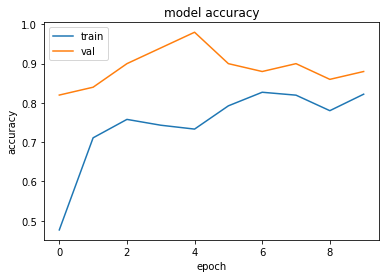

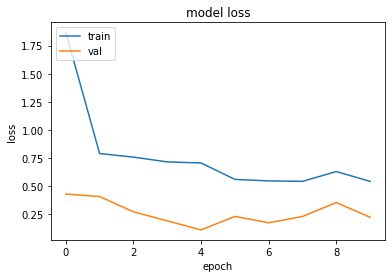

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline 

def plot_results(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_results(history)

## Test the model 

In [11]:
pred = model.predict_generator(test_generator)
predicted_class_indices = np.argmax(pred, axis = 1)
results_df = pd.DataFrame(
    {
        'id': pd.Series(test_generator.filenames), 
        'label': pd.Series(predicted_class_indices)
    })
results_df['id'] = results_df.id.str.extract('(\d+)')
results_df['id'] = pd.to_numeric(results_df['id'], errors = 'coerce')
results_df.sort_values(by='id', inplace = True)
results_df.head()

Instructions for updating:
Please use Model.predict, which supports generators.


,id,label
101,2,2
60,3,1
228,5,4
231,6,1
234,7,4


In [12]:
scores = model.evaluate_generator(test_generator) 
print('Accuracy:', scores[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
Accuracy: 0.824701189994812


## Tunning 

### Early stopping
Use early stopping and see if our results change

Epoch 1/10
81/81 [==============================] - 24s 301ms/step - loss: 0.3577 - accuracy: 0.8691 - val_loss: 0.1234 - val_accuracy: 0.9600
Epoch 2/10
81/81 [==============================] - 25s 312ms/step - loss: 0.4334 - accuracy: 0.8642 - val_loss: 0.2197 - val_accuracy: 0.9000
Epoch 3/10
81/81 [==============================] - 28s 341ms/step - loss: 0.3831 - accuracy: 0.8765 - val_loss: 0.1563 - val_accuracy: 0.9200


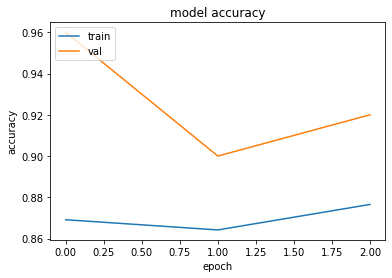

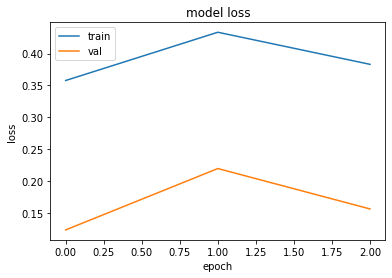

Accuracy: 0.8486055731773376


In [16]:
EARLY_STOP_PATIENCE=2
# Early stopping 
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)

history = model.fit_generator(train_generator, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator) // BS,
                    steps_per_epoch=len(train_generator) // BS, 
                    epochs=EPOCHS,
                    callbacks=[cb_early_stopper])
plot_results(history)
scores = model.evaluate_generator(test_generator) 
print('Accuracy:', scores[1])

Show some of the images, comparing the original class with the assigned class

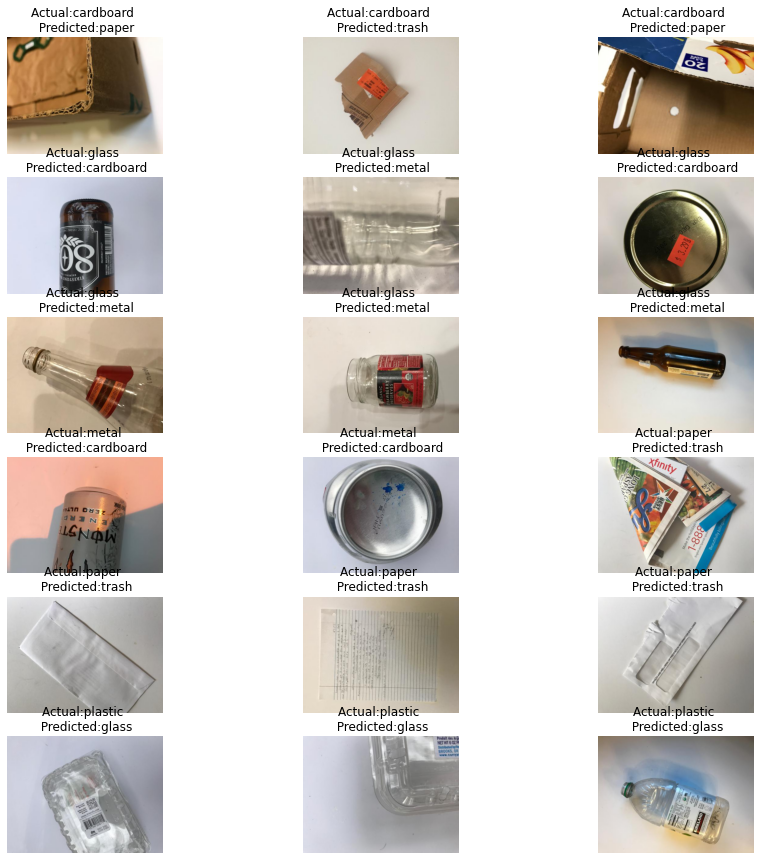

In [15]:
# example: #https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50
import os
classes = os.listdir('dataset-resized/test/')
total = []
for i in range(0, len(classes)):
    path, dirs, files = next(os.walk("dataset-resized/test/" + classes[i]))
    total.append(len(files))
import os
classes = os.listdir('dataset-resized/test/')
import cv2
TEST_DIR = 'dataset-resized/test/'
f, ax = plt.subplots(6, 3, figsize = (15, 15))

j=0
index = 0
for j in range(0, len(classes)):
    for i in range(0, 3):
        imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[index])
        imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
        ax[j, i].imshow(imgRGB)
        ax[j, i].axis('off')
        ax[j, i].set_title("Actual:{} \n Predicted:{}".format((test_generator.filenames[index].split('/')[0]), 
                                                 classes[predicted_class_indices[index]]))    
        index = index+1
    index = index + total[i]
plt.show()